<a href="https://colab.research.google.com/github/rolandoteniya/obesity-classification-machine-learning/blob/main/Obesity_Classification_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# University of Liverpool

## COMP634 - Applied AI

---

This notebook is associated with Assignment 1. Use it to complete the assignment by following the instructions provided in each section, which includes a text cell describing the requirements. For additional details, see the Canvas.

Use this first cell to import the necessary libraries.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("/content/drive/MyDrive/Applied AI/assignment1-dataset.csv")

# 1. **Data Management**


In this part, you need to:

1.   analyse and prepare the data. Use plots, graphs, and tables (such as histogram, box plots, scatterplots etc.) to better analyse the dataset and identify issues or potential improvements in the data, including (but not limited to) unnecessary feature/variable which can be dropped/removed, standardization, encoding, etc;
2.   split the data and define your experimental protocol (such as cross-validation or k-fold).

Null Values:
Gender               0
Age                  0
Height               0
Weight               0
family_overweight    0
HCF                  0
VegMeals             0
Meals                0
FD                   0
MealsBetw            0
SMOKE                0
WaterQ               0
CaloriesMonitor      0
PhysAct              0
TechUsage            0
AlcConsume           0
TransMeans           0
ObesityLvl           0
dtype: int64 



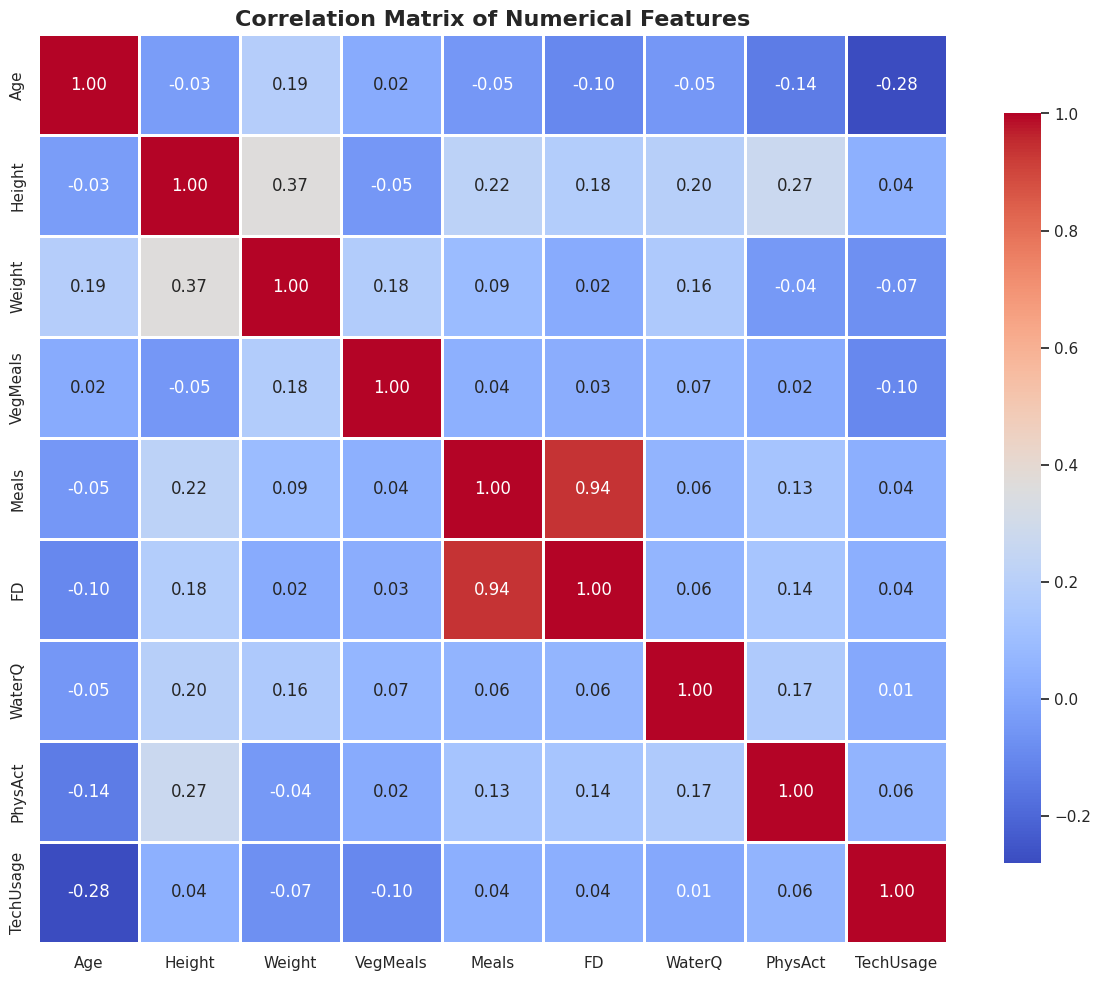

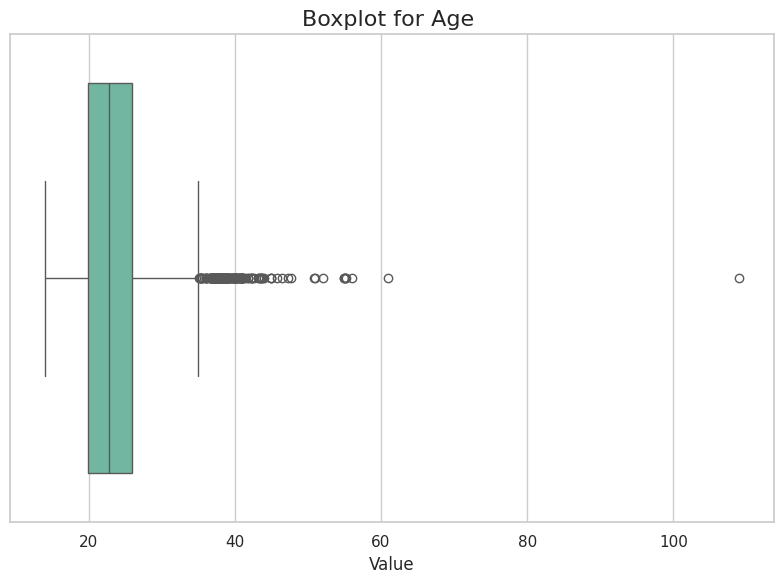

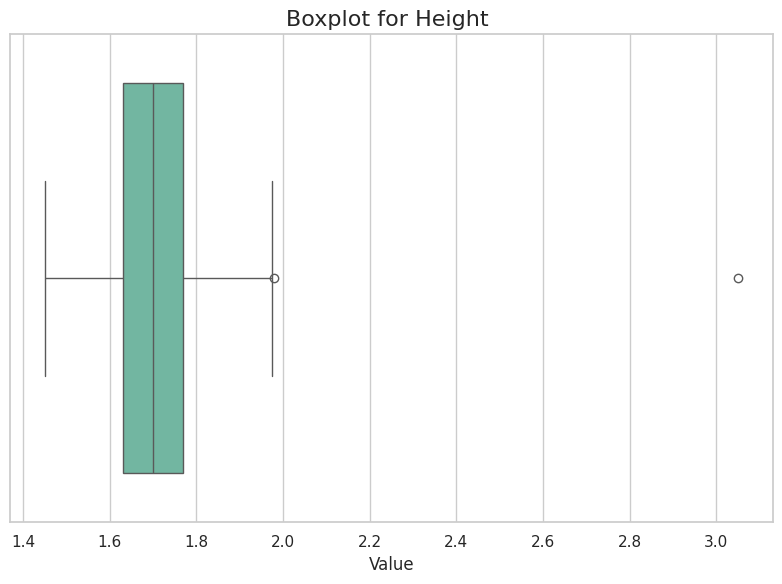

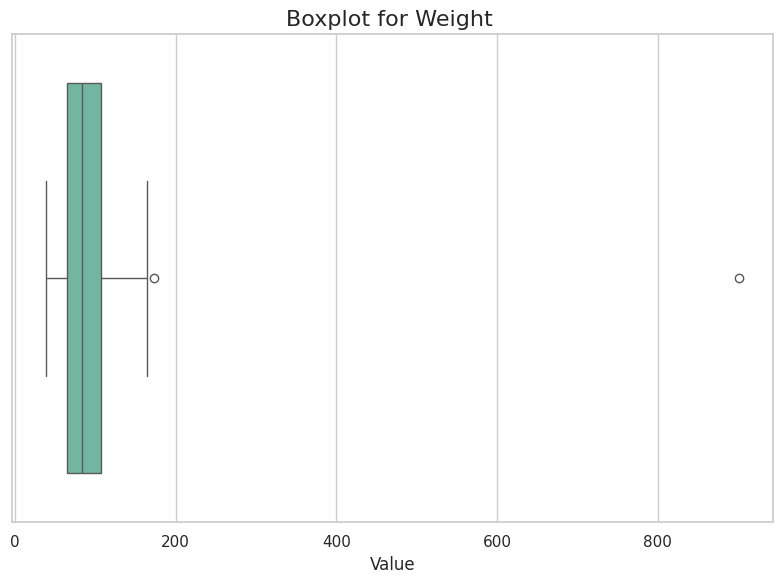

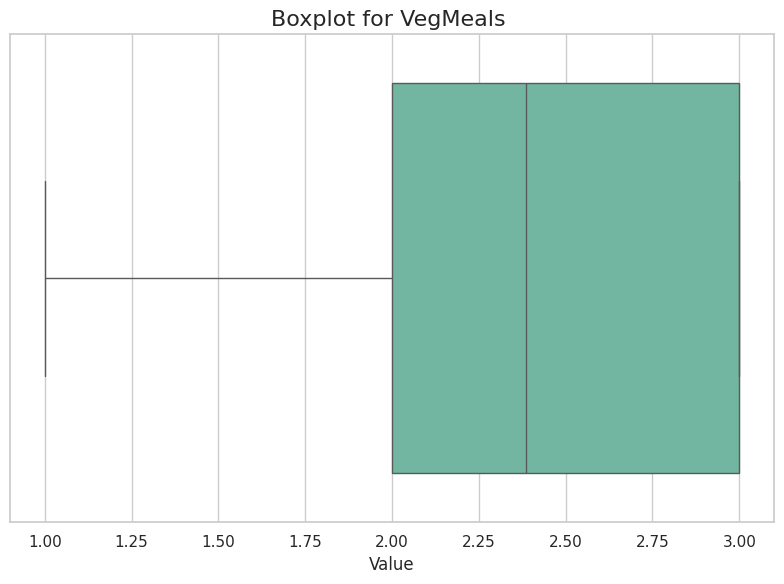

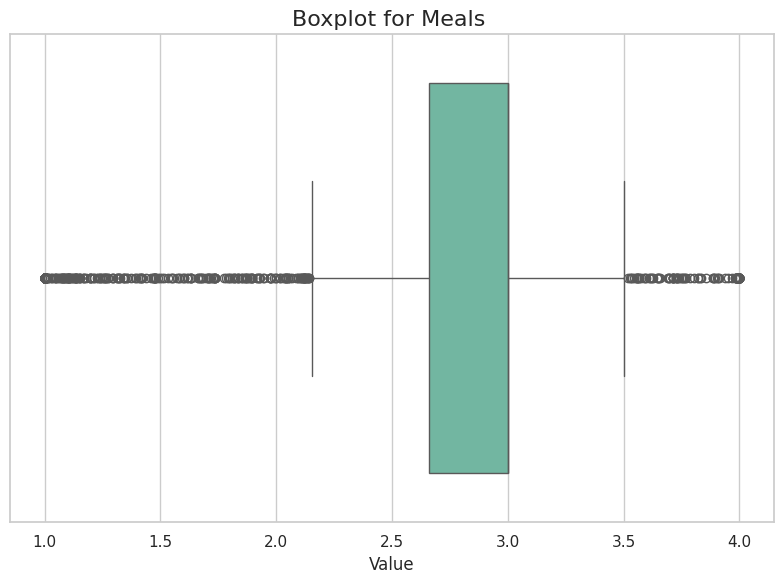

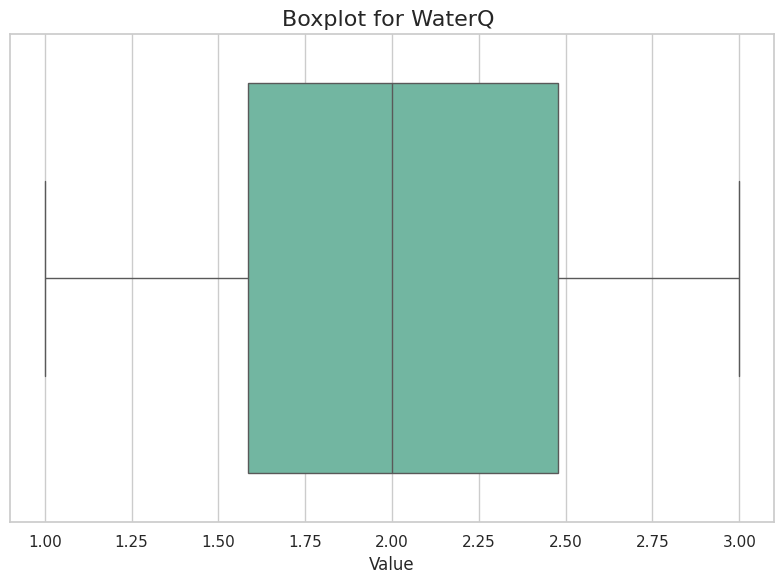

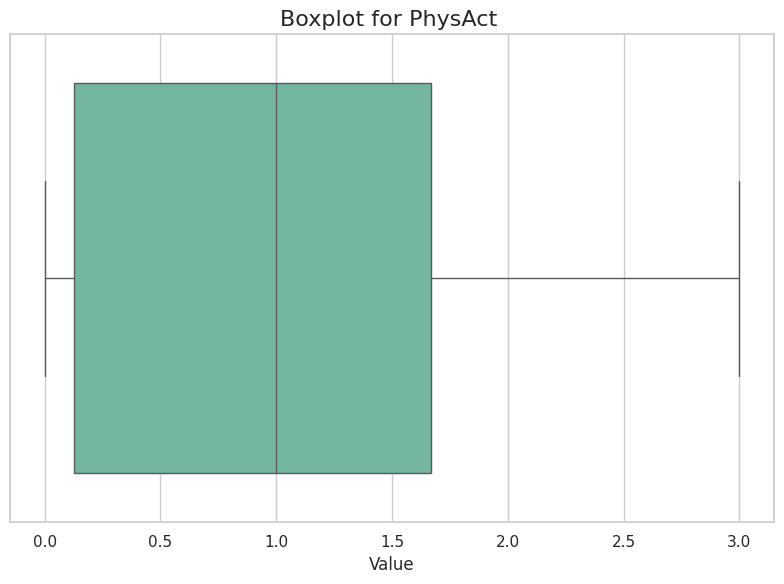

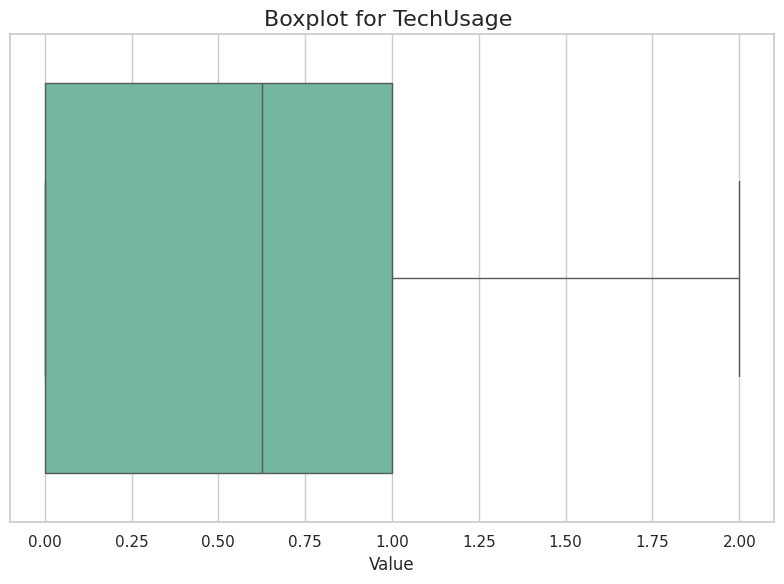

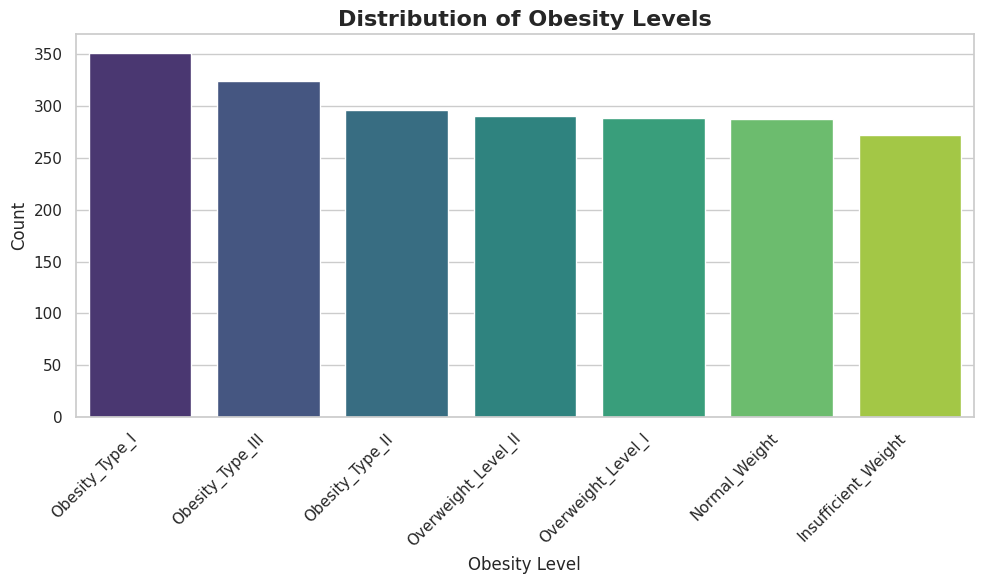

ObesityLvl
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        296
Overweight_Level_II    290
Overweight_Level_I     288
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64


In [ ]:
# Box plots
sns.set_theme(style="whitegrid")

cols_to_plot = ['Age', 'Height', 'Weight', 'VegMeals', 'Meals','FD', 'WaterQ', 'PhysAct', 'TechUsage']

# Check nulls
print("Null Values:")
print(df.isnull().sum(),"\n")

# Correlation analysis for numerical features
plt.figure(figsize=(12, 10))
heatmap_cols = [col for col in cols_to_plot if col in df.columns]
correlation_matrix = df[heatmap_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Drop FD
df_dropped = df.drop(columns=['FD'], inplace=True,errors='ignore')
cols_to_plot.remove('FD')

# Plot the box plots for numerical coloumns
numeric_df_cols = [col for col in cols_to_plot if col in df.columns]

for column in numeric_df_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df[column], palette="Set2")
    plt.title(f'Boxplot for {column} ', fontsize=16)
    plt.xlabel('Value', fontsize=12)
    plt.tight_layout()
    plt.show()

# Remove outliers using thresholds
initial_rows = len(df)

# Define thresholds
height_threshold = 2.5
weight_threshold = 200
age_threshold = 100

# Apply threshold
df_dropped = df[(df['Height'] < height_threshold) & (df['Weight'] < weight_threshold) & (df['Age'] < age_threshold)]

# Target variable distribution
plt.figure(figsize=(10, 6))
obesity_counts = df_dropped['ObesityLvl'].value_counts()
sns.barplot(x=obesity_counts.index, y=obesity_counts.values, palette='viridis')
plt.title('Distribution of Obesity Levels', fontsize=16, fontweight='bold')
plt.xlabel('Obesity Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print(obesity_counts)

# Ground truth
df_dropped['ObesityLvl'] = df_dropped['ObesityLvl'].replace({
    'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Overweight_Level_I': 2, 'Overweight_Level_II': 3,
    'Obesity_Type_I': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6
})

# Label encoding
df_dropped['MealsBetw'] = df_dropped['MealsBetw'].replace({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
df_dropped['AlcConsume'] = df_dropped['AlcConsume'].replace({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})

# One-hot encoding
df_encoded = pd.get_dummies(df_dropped, columns=['family_overweight', 'HCF', 'SMOKE', 'CaloriesMonitor', 'Gender', 'TransMeans'], drop_first=True)

In [ ]:
# Use un-scaled data
X = df_encoded.drop(columns=['ObesityLvl'])
y = df_encoded['ObesityLvl']

# Split data into training and test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data Split:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify class distribution
print("\nClass distribution in splits:")
print("Training:", y_train.value_counts().sort_index().values)
print("Test:", y_test.value_counts().sort_index().values)

num_cols = ['Age', 'Height', 'Weight', 'VegMeals', 'Meals', 'WaterQ', 'PhysAct', 'TechUsage', 'MealsBetw', 'AlcConsume']

scaler = StandardScaler()

# Fit the scaler only on the training data
X_train.loc[:, num_cols] = scaler.fit_transform(X_train[num_cols])

# Use that same scaler to transform the test data without fitting
X_test.loc[:, num_cols] = scaler.transform(X_test[num_cols])


Data Split:
Training set: 1686 samples (80.0%)
Test set: 422 samples (20.0%)

Class distribution in splits:
Training: [218 229 230 232 281 237 259]
Test: [54 58 58 58 70 59 65]


---

# 2. **Model Training**

Here, you need to:

1.	select and compare at least three machine learning models (seen/discussed during the lectures) appropriate for your modelling;
2.	if there are hyperparameters in a selected algorithm, define a hyperparameter search protocol (you can define your own), and tune them.


## Baseline Models

In [ ]:
# Initialise models
baseline_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Store baseline results
baseline_results = {}

# Define cross-validation strategy for baseline evaluation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Training Baseline Models with Cross-Validation\n")

for name, model in baseline_models.items():
    # Use cross-validation on training set using 4 different metrics
    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv_strategy,
        scoring=['accuracy', 'f1_weighted', 'recall_weighted', 'precision_weighted']
    )

    accuracy = cv_results['test_accuracy'].mean()
    f1 = cv_results['test_f1_weighted'].mean()
    recall = cv_results['test_recall_weighted'].mean()
    precision = cv_results['test_precision_weighted'].mean()

    baseline_results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'recall': recall,
        'precision': precision
    }

    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Precision: {precision:.4f}\n")

Training Baseline Models with Cross-Validation

Decision Tree:
  Accuracy: 0.9241
  F1-Score: 0.9237
  Recall: 0.9241
  Precision: 0.9252

Random Forest:
  Accuracy: 0.9484
  F1-Score: 0.9488
  Recall: 0.9484
  Precision: 0.9513

SVM:
  Accuracy: 0.9116
  F1-Score: 0.9123
  Recall: 0.9116
  Precision: 0.9149

KNN:
  Accuracy: 0.8114
  F1-Score: 0.8006
  Recall: 0.8114
  Precision: 0.8101

Naive Bayes:
  Accuracy: 0.5409
  F1-Score: 0.4600
  Recall: 0.5409
  Precision: 0.5063

Logistic Regression:
  Accuracy: 0.8737
  F1-Score: 0.8716
  Recall: 0.8737
  Precision: 0.8754



Remove Naive Bayes because it has a very low accuracy compared to the other 5.

## Hyperparameter Tuning

We will now tune hyperparameters for the top 5 models using GridSearchCV with 5-fold Stratified Cross-Validation.

### 1. Decision Tree Hyperparameter Tuning

In [ ]:
print("Decision Tree\n")

# Define hyperparameter grid
dt_param_grid = {
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Total number of combinations
total_combinations = 1
for parameter_values in dt_param_grid.values():
  total_combinations = total_combinations * len(parameter_values)

print(f"Total combinations: {total_combinations}")

# Grid search with cross-validation
dt_grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Starting grid search
dt_grid_search.fit(X_train, y_train)

print("\nResults:")

print(f"Best parameters: {dt_grid_search.best_params_}")
print(f"Best Accuracy: {dt_grid_search.best_score_:.4f}")

Decision Tree

Total combinations: 160
Fitting 5 folds for each of 160 candidates, totalling 800 fits

Results:
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Accuracy: 0.9401


### 2. Random Forest Hyperparameter Tuning

In [ ]:
print("Random Forest\n")

# Define hyperparameter grid
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Total number of combinations
total_combinations = 1
for parameter_values in rf_param_grid.values():
  total_combinations = total_combinations * len(parameter_values)

print(f"Total combinations: {total_combinations}")

# Grid search with cross-validation
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Start grid search
rf_grid_search.fit(X_train, y_train)

print("\nResults:")

print(f"Best Parameters: {rf_grid_search.best_params_}")
print(f"Best Accuracy: {rf_grid_search.best_score_:.4f}")

Random Forest

Total combinations: 108
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Results:
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.9537


### 3. SVM Hyperparameter Tuning

In [ ]:
print("SVM\n")

# Define hyperparameter grid
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Total number of combinations
total_combinations = 1
for parameter_values in svm_param_grid.values():
  total_combinations = total_combinations * len(parameter_values)

print(f"Total combinations: {total_combinations}")

# Grid search with cross-validation
svm_grid_search = GridSearchCV(
    SVC(random_state=42),
    svm_param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Start grid search
svm_grid_search.fit(X_train, y_train)


print("\nResults:")

print(f"Best Parameters: {svm_grid_search.best_params_}")
print(f"Best Accuracy: {svm_grid_search.best_score_:.4f}")

SVM

Total combinations: 24
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Results:
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Accuracy: 0.9614


### 4. KNN Hyperparameter Tuning

In [ ]:
print("KNN\n")

# Define hyperparameter grid
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Total number of combinations
total_combinations = 1
for parameter_values in knn_param_grid.values():
  total_combinations = total_combinations * len(parameter_values)

print(f"Total combinations: {total_combinations}")

# Grid search with cross-validation
knn_grid_search = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Start grid search
knn_grid_search.fit(X_train, y_train)

print("\nResults:")

print(f"Best Parameters: {knn_grid_search.best_params_}")
print(f"Best Accuracy: {knn_grid_search.best_score_:.4f}")

KNN

Total combinations: 42
Fitting 5 folds for each of 42 candidates, totalling 210 fits

Results:
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best Accuracy: 0.8820


### 5. Logistic Regression Hyperparameter Tuning

In [ ]:
print("Logistic Regression\n")

# Define hyperparameter grid
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000, 2000]
}

# Total number of combinations
total_combinations = 1
for parameter_values in lr_param_grid.values():
  total_combinations = total_combinations * len(parameter_values)

print(f"Total combinations: {total_combinations}")

# Grid search with cross-validation
lr_grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    lr_param_grid,
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Start grid search
lr_grid_search.fit(X_train, y_train)


print("\nResults:")

print(f"Best Parameters: {lr_grid_search.best_params_}")
print(f"Best Accuracy: {lr_grid_search.best_score_:.4f}")

Logistic Regression

Total combinations: 40
Fitting 5 folds for each of 40 candidates, totalling 200 fits

Results:
Best Parameters: {'C': 10, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}
Best Accuracy: 0.9555


### Comparison

In [ ]:
# Create a dictionary with both baseline and tuned scores
comparison_data = {
    'Model': [
        'Decision Tree',
        'Random Forest',
        'SVM',
        'KNN',
        'Logistic Regression'
    ],
    'Baseline Accuracy': [
        baseline_results['Decision Tree']['accuracy'],
        baseline_results['Random Forest']['accuracy'],
        baseline_results['SVM']['accuracy'],
        baseline_results['KNN']['accuracy'],
        baseline_results['Logistic Regression']['accuracy']
    ],
    'Tuned Accuracy': [
        dt_grid_search.best_score_,
        rf_grid_search.best_score_,
        svm_grid_search.best_score_,
        knn_grid_search.best_score_,
        lr_grid_search.best_score_
    ],

}

# Create a DataFrame in order to store the before and after results to determine the best score and the improvement
comparison_df = pd.DataFrame(comparison_data)

# Calculate the improvement
comparison_df['Improvement'] = comparison_df['Tuned Accuracy'] - comparison_df['Baseline Accuracy']

# Sort by the best tuned score
comparison_df = comparison_df.sort_values(by='Tuned Accuracy', ascending=False)

print("Model Performance Comparison")

# Display the full comparsion table
pd.set_option('display.max_colwidth', None)
print(comparison_df.to_string(index=False))

# Identify the best model
best_model_name = comparison_df.iloc[0]['Model']
best_cv_score = comparison_df.iloc[0]['Tuned Accuracy']

print(f"Best Model: {best_model_name}")
print(f"Accuracy: {best_cv_score:.4f}")


Model Performance Comparison
              Model  Baseline Accuracy  Tuned Accuracy  Improvement
                SVM           0.911636        0.961440     0.049804
Logistic Regression           0.873671        0.955512     0.081841
      Random Forest           0.948401        0.953744     0.005343
      Decision Tree           0.924081        0.940101     0.016020
                KNN           0.811404        0.881973     0.070569
Best Model: SVM
Accuracy: 0.9614


---

# 3. **Evaluate models**

Here, you need to:

1.	test the model (the best one you obtained from the above stage) on the appropriate set


## Select Best Model and Test on Test Set

In [ ]:
# Get the best model based on the comparison
model_mapping = {
    'Decision Tree': dt_grid_search.best_estimator_,
    'Random Forest': rf_grid_search.best_estimator_,
    'SVM': svm_grid_search.best_estimator_,
    'KNN': knn_grid_search.best_estimator_,
    'Logistic Regression': lr_grid_search.best_estimator_
}

best_model = model_mapping[best_model_name]


print(f"Evaluating Best Model: {best_model_name}")

print(f"\nBest Hyperparameters:")
if best_model_name == 'Decision Tree':
    print(dt_grid_search.best_params_)
elif best_model_name == 'Random Forest':
    print(rf_grid_search.best_params_)
elif best_model_name == 'SVM':
    print(svm_grid_search.best_params_)
elif best_model_name == 'KNN':
    print(knn_grid_search.best_params_)
else:
    print(lr_grid_search.best_params_)

print(f"\nAccuracy: {best_cv_score:.4f}")


Evaluating Best Model: SVM

Best Hyperparameters:
{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

Accuracy: 0.9614


In [ ]:
# Predict on test set
y_test_pred = best_model.predict(X_test)

# Calculate the weighted metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')

# Also calculate macro metrics (treats all classes equally)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')


print(f"Test Set Evaluation - {best_model_name}")

# Create a summary table
test_results_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (weighted)', 'Recall (weighted)', 'F1-Score (weighted)',
               'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)'],
    'Score': [test_accuracy, test_precision, test_recall, test_f1,
              test_precision_macro, test_recall_macro, test_f1_macro]
})

print(test_results_summary.to_string(index=False))

Test Set Evaluation - SVM
              Metric    Score
            Accuracy 0.959716
Precision (weighted) 0.960444
   Recall (weighted) 0.959716
 F1-Score (weighted) 0.959571
   Precision (macro) 0.960298
      Recall (macro) 0.959123
    F1-Score (macro) 0.959187


## Confusion Matrix

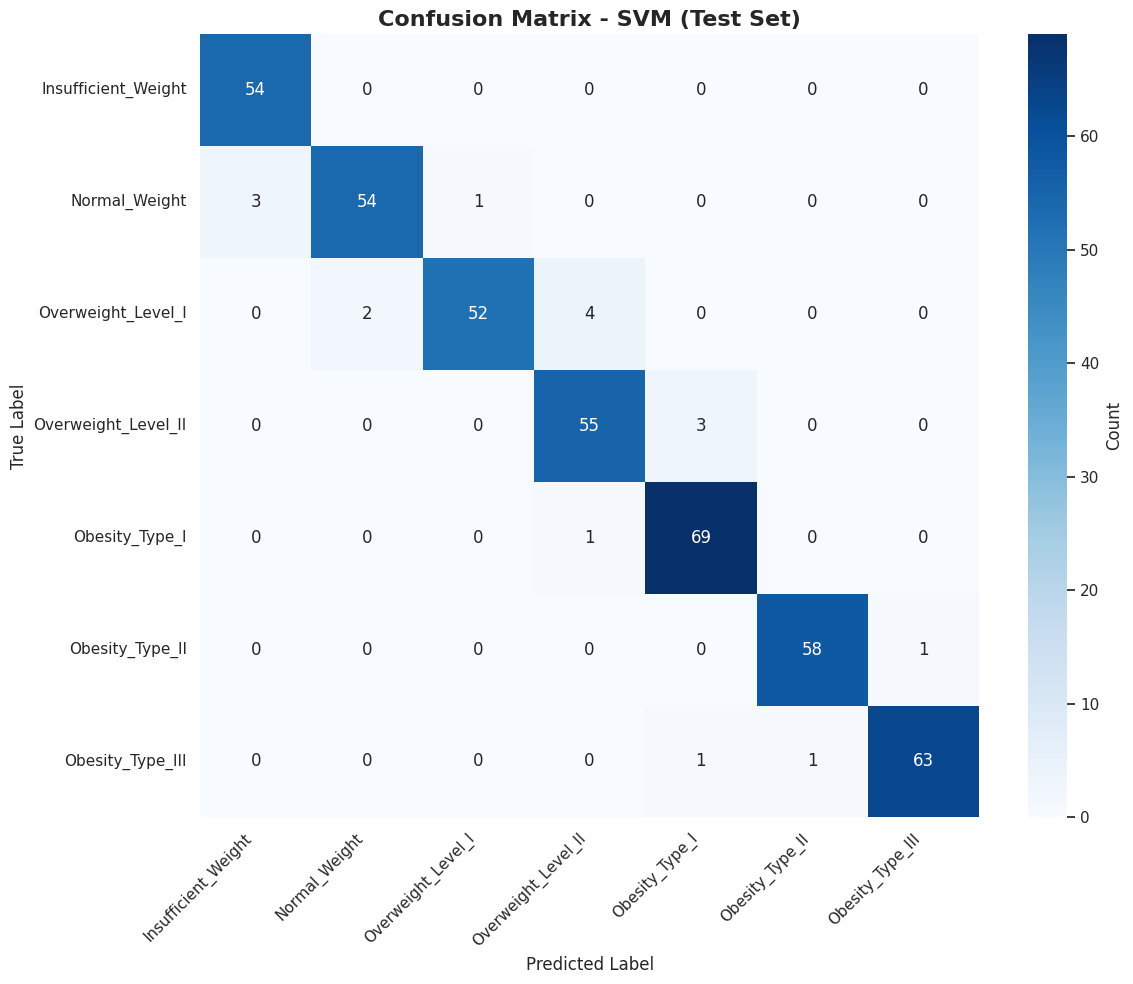


Confusion Matrix Statistics:
Total test samples: 422
Correctly classified: 405 (95.97%)
Misclassified: 17 (4.03%)


In [ ]:
# Convert to dataframe for better visualization
class_names = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
               'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

report = classification_report(y_test, y_test_pred, target_names=class_names)
report_dict = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name} (Test Set)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print summary statistics from confusion matrix
print("\nConfusion Matrix Statistics:")
print(f"Total test samples: {cm.sum()}")
print(f"Correctly classified: {np.trace(cm)} ({np.trace(cm)/cm.sum()*100:.2f}%)")
print(f"Misclassified: {cm.sum() - np.trace(cm)} ({(cm.sum() - np.trace(cm))/cm.sum()*100:.2f}%)")